<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Double descent

**Week 2, Day 1: Macrocircuits**

**By Neuromatch Academy**

__Content creators:__ Andrew Saxe, Vidya Muthukumar

__Content reviewers:__ Max Kanwal, Surya Ganguli, Xaq Pitkow, Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 1 hour*

In this tutorial we'll look at the sometimes surprising behavior of large neural networks, which is called as double descent. This empirical phenomenon puts the classical understanding of the bias-variance tradeoff, which states that we expect to observe poor test performance with the model's overfit (with increase in its complexity), under the question. In pacticular, we will explore the following: 

- notions of low/high bias/variance;
- improvement of test performance with the network's overparameterization which leads to large models trend;
- the conditions for double descent to be observed and what affects its significance;
- the conditions for double descent to fail.
  
Let's jump in!

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

# from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"
# print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup

In [13]:
# @title Imports

import numpy as np
import matplotlib.pyplot as plt
import logging
import torch

In [14]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [15]:
# @title Plotting functions

def plot_fit(x_train, y_train, x_test, y_test, y_pred = 0):
    """
    Plot train and test data (as well as predicted values for test if given).
    
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    """
    with plt.xkcd():
        plt.plot(x_test, y_test,label='Test data')
        plt.plot(x_train, y_train,'o',label='Training data')
        if y_pred:
            plt.plot(x_test, y_pred, label='Prediction')
        plt.legend()
        plt.xlabel('Input Feature')
        plt.ylabel('Target Output')

def predict(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Plot predicted values for test set.
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - reg (float, default = 0): regularization term.
    """
    y_pred = fit_relu(x_train, y_train, x_test, y_test, n_hidden, reg)[2]

    with plt.xkcd():
        plt.plot(x_test, y_test,linewidth=4,label='Test data')
        plt.plot(x_train, y_train,'o',label='Training data')
        plt.plot(x_test, y_pred, color='g', label='Prediction')
        plt.xlabel('Input Feature')
        plt.ylabel('Target Output')
        plt.title('Number of Hidden Units = {}'.format(n_hidden))
        plt.show()

In [16]:
# @title Helper functions

def sin_dataset(sigma = 0):
    """
    Create a sinusoidal dataset and sample 10 points from it for a training dataset.
    Training set incorporates Gaussian noise added to the target values of the given standard deviation.

    Inputs:
    - sigma (float, default = 0): standard deviation of the train noise.

    Outputs:
    - x_train, y_train, x_test, y_test (tuple of np.ndarray): train and test data.
    """

    # Create a sinusoidal dataset and sample 10 points from it for a training dataset
    x_test = np.linspace(-np.pi, np.pi, 100)
    y_test = np.sin(x_test)

    x_train = np.linspace(-np.pi, np.pi, 10)
    # y_train = np.sin(x_train) + 0.05 * np.random.normal(size=10)
    y_train = np.sin(x_train) + sigma * np.random.normal(size=10)

    return x_train.reshape(10,1), y_train.reshape(10,1), x_test.reshape(100,1), y_test.reshape(100,1)


def fit_relu_init_scale(x_train, y_train, x_test, y_test, init_scale = 0, n_hidden = 10, reg = 0):
    """
    Fit second layer of network by solving for linear regression with pseudo-inverse for the given training data and evaluate the performance on test one.

    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - init_scale (float, default = 0): initial standard deviation for weights in the second layer.
    - n_hidden (int, default = 10): size of hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0,1, (n_inputs, n_hidden))  # Random weights
    b1 = np.random.uniform(-np.pi, np.pi, size=(1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.random.normal(0,init_scale,(n_hidden, n_outputs))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        z2 = a1.dot(W2) 
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    hidden_pinv = np.dot(np.linalg.pinv(np.dot(hidden.T, hidden) + reg*np.eye(n_hidden)), hidden.T)
    W2 = hidden_pinv.dot(y_train) + (np.eye(n_hidden) - hidden_pinv @ hidden) @ W2   # Pseudo-inverse solution plus component in data nullspace

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)
    
    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)
    
    return train_err, test_err, y_pred

def sweep_test_init_scale(x_train, y_train, x_test, y_test, init_scale = 0, n_hidden = 10, n_reps = 20):
    """
    Calculate mean test error for fitting second layer of network for defined number of repetitions.
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - init_scale (float, default = 0): initial standard deviation for weights in the second layer.
    - n_hidden (int, default = 10): size of hidden layer.

    Outputs:
    - (float): mean error for test data.
    """
    return np.mean(np.array([fit_relu_init_scale(x_train, y_train, x_test, y_test, init_scale=init_scale, n_hidden=n_hidden)[1] for i in range(n_reps)]))

def sweep_train(x_train, y_train, x_test, y_test, n_hidden = 10, n_reps = 20):
    """
    Calculate mean train error for fitting second layer of network for defined number of repetitions.
    Notice that `init_scale` is always set to be 0 in this case.
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.

    Outputs:
    - (float): mean error for train data.
    """
    return np.mean(np.array([fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hidden)[0] for i in range(n_reps)]))

In [17]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [6]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

---
# Section 1: Overfitting in overparameterized models

In this section we will observe the classical behaviour of overparametrized networks - overfitting.

In [7]:
# @title Video 2: Overfitting in Overparameterized Models

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

## Coding Exercise 1: Learning with a simple neural network

We start by generating a simple sinusoidal dataset.

This dataset contains 100 data points, from which we've subselected just ten for our training dataset. 

*Notice that training set contains noise (points are not located perfectly on the sinusoid). (RIGHT NOW NOT TRUE)*

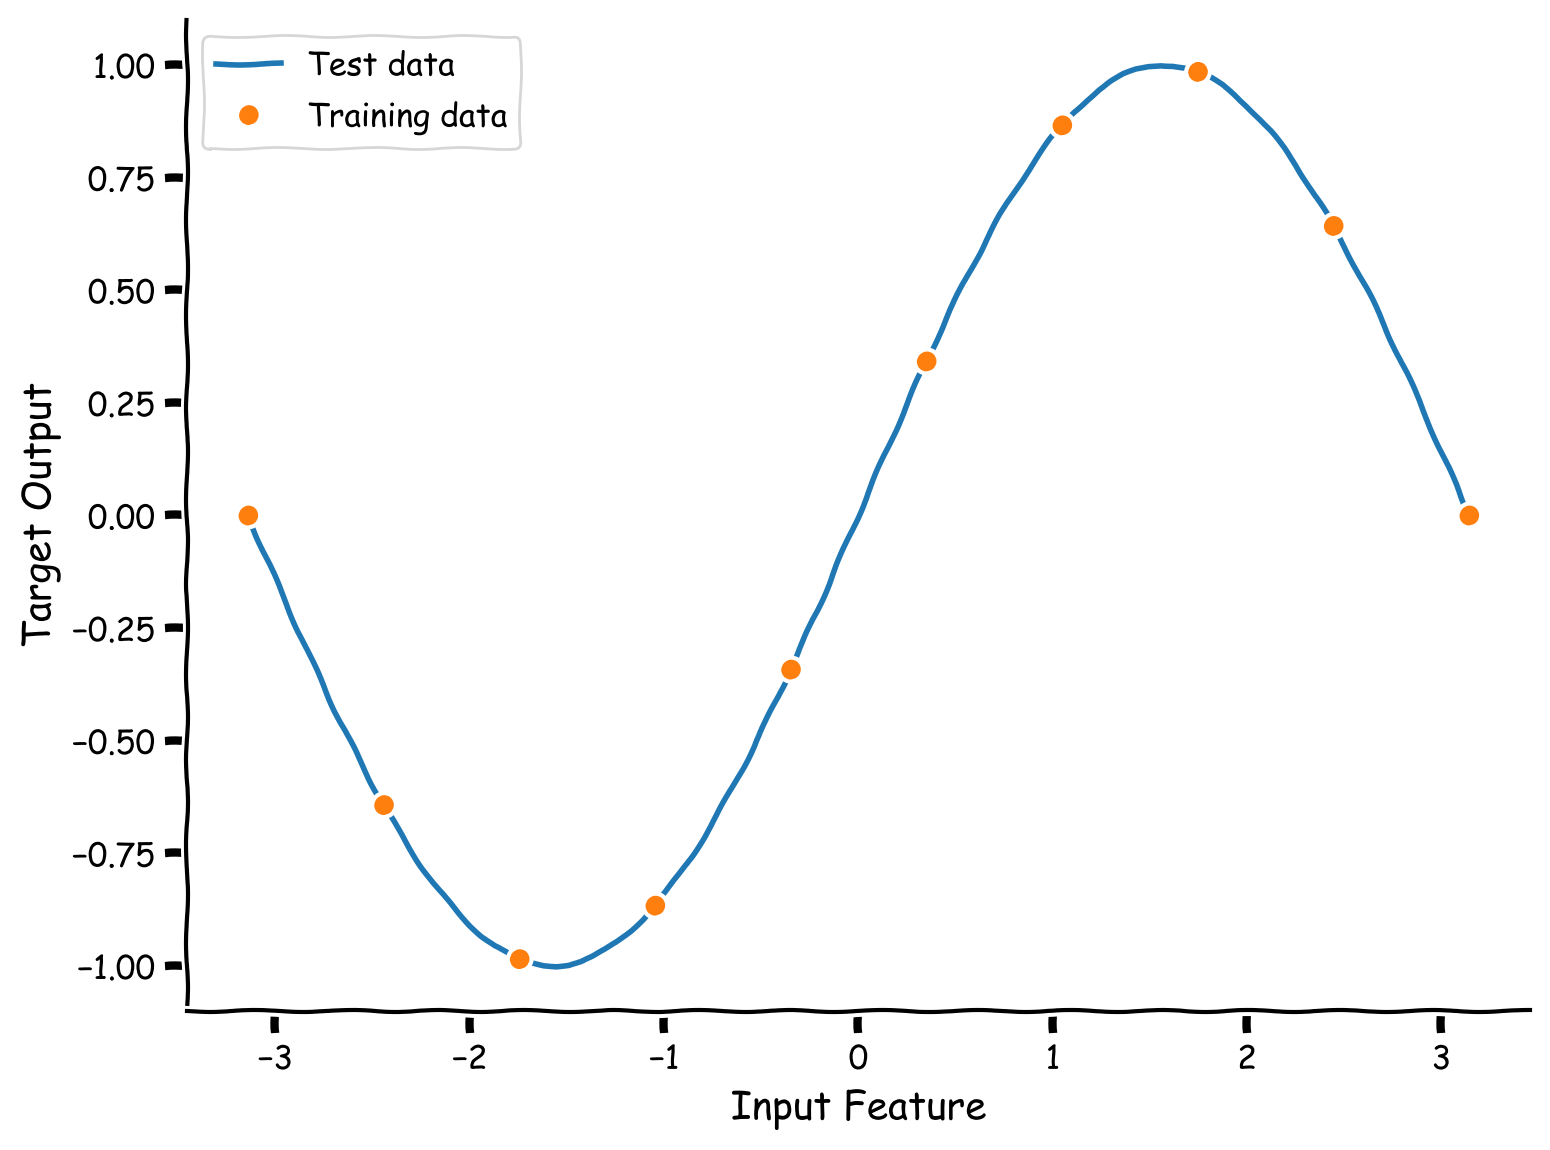

In [8]:
# @markdown Sample and plot sinusoidal dataset

set_seed(42)
x_train, y_train, x_test, y_test = sin_dataset()

plot_fit(x_train, y_train, x_test, y_test)

We'll learn this task with a simple neural network: a one hidden layer ReLU network, where the first layer is fixed and random.

That is, the network computes its hidden activity as $h = ReLU(W_1x + b)$, and its output as $\hat y = W_2h$. 

The input $x\in R$ is a scalar. There are $N_h$ hidden units, and the output $\hat y\in R$ is a scalar.

We will initialize $W_1$ with i.i.d. random Gaussian values with a variance of one, and $b$ with values drawn i.i.d. uniformly between $-\pi$ and $\pi$. Finally, we will initialize the weights $W_2$ to zero.

We only train $W_2$, leaving $W_1$ and $b$ fixed. We can train $W_2$ to minimize the mean squared error between the training labels $y$ and the network's output on those datapoints. 

Usually we would train this network using gradient descent, but here we've taken advantage of the fixed first layer to compute the same final solution as gradient descent using linear regression. This is much faster and will let us rapidly train many networks.

<details open>
<summary> Closed-form solution derivation (optional)</summary>
<br>

To find $W_2$, we will rewrite the problem in matrix form. Let:
- $X$ be the matrix of input data (shape $ n \times 1 $)
- $H$ be the matrix of hidden activations after ReLU (shape $ n \times N_h $)
- $y$ be the vector of target outputs (shape $n \times 1$)

$W_1$, $W_2$ and $b$ are of shape $N_h \times 1$.

Compute the hidden activations:
$$
H = \text{ReLU}(X W_1^\top + b)
$$

The predicted outputs can be written as:
$$
\hat{y} = H W_2
$$

We aim to minimize the mean squared error (MSE) between the predicted output $\hat{y}$ and the true output $y$:

$$
\text{MSE} = (H W_2 - y)^2
$$

By taking derivative of this expression by $W_2$, we get:

$$
2H^\top HW_2 - 2H^\top y = 0
$$

Meaning that, optimal solution $W_2$ is

$$
W_2 = (H^\top H)^{-1}H^\top y
$$

It is possible that $H^\top H$ is not invertible. Then, we use the Moore-Penrose pseudoinverse $(H^\top H)^+$ to find the optimal $W_2$:
$$
W_2 = (H^\top H)^+ H^\top y
$$

</details>


Below is skeleton code for this network. Your task is to implement its weight initialization and forward pass function. In the cell below you can test your solution.

In [ ]:
def fit_relu(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Fit second layer of network by solving via linear regression for the given training data and evaluate the performance.

    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete initialization of layers as well as forward propagation for the network (follow the description in the text above).")
    ###################################################################

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0, ..., (n_inputs, ...))  # Random weights
    b1 = np.random.uniform(-np.pi, ..., size = (1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.zeros((..., ...))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(...) + ...
        a1 = np.maximum(0, ...)  # ReLU activation
        z2 = a1.dot(...) 
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    hidden_pinv = np.dot(np.linalg.pinv(np.dot(hidden.T, hidden) + reg*np.eye(n_hidden)), hidden.T)
    W2 = hidden_pinv.dot(y_train) + (np.eye(n_hidden) - hidden_pinv @ hidden)  @ W2   # Pseudo-inverse solution plus component in data nullspace

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)
    
    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)
    
    return train_err, test_err, y_pred

In [18]:
#to_remove solution

def fit_relu(x_train, y_train, x_test, y_test, n_hidden = 10, reg = 0):
    """
    Fit second layer of network by solving via linear regression for the given training data and evaluate the performance.

    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - reg (float, default = 0): regularization term.

    Outputs:
    - train_err (float): train error value.
    - test_err (float): test error value.
    - y_pred (np.ndarray): array of predicted values for test data.
    """

    # Define network architecture
    n_inputs = 1  # Number of input features
    n_outputs = 1  # Number of output units

    # Layer 1 (Input -> Hidden)
    W1 = np.random.normal(0, 1, (n_inputs, n_hidden))  # Random weights
    b1 = np.random.uniform(-np.pi, np.pi, size = (1, n_hidden))  # Bias

    # Layer 2 (Hidden -> Output)
    W2 = np.zeros((n_hidden, n_outputs))  # Initialize weights to zero

    # Forward propagation
    def forward_prop(X):
        z1 = X.dot(W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        z2 = a1.dot(W2) 
        return z2

    # Fit second layer weights with linear regression
    hidden = np.maximum(0, x_train.dot(W1) + b1)  # Hidden layer activations
    hidden_pinv = np.dot(np.linalg.pinv(np.dot(hidden.T, hidden) + reg*np.eye(n_hidden)), hidden.T)
    W2 = hidden_pinv.dot(y_train) + (np.eye(n_hidden) - hidden_pinv @ hidden)  @ W2   # Pseudo-inverse solution plus component in data nullspace

    # Train Error
    y_pred = forward_prop(x_train)
    train_err = np.mean((y_train-y_pred)**2/2)
    
    # Test Error
    y_pred = forward_prop(x_test)
    test_err = np.mean((y_test-y_pred)**2/2)
    
    return train_err, test_err, y_pred

## Coding Exercise 2: The bias-variance tradeoff

With the network implemented, we now investigate how the size of the network (the number of hidden units it has, $N_h$) relates to its ability to generalize. 

Ultimately, the true measure of a learning system is how well it performs on novel inputs, that is, its ability to generalize. The classical story of how model size relates to generalization is the bias-variance tradeoff.

To start, complete the code below to train several small networks with just two hidden neurons and plotting their predictions.

In [ ]:
set_seed(42)

n_hid = 2

n_reps = 10 # Number of networks to train

def plot_predictions(n_hid, n_reps):
    """
    Generate train and test data for `n_reps` times, fit it for network with hidden size `n_hid` and plot prediction values.

    Inputs:
    - n_hid (int): size of hidden layer.
    - n_reps (int): number of data regenerations.
    """
    with plt.xkcd():
        plt.plot(x_test, y_test,linewidth=4,label='Test data')
        plt.plot(x_train, y_train,'o',label='Training data')
    
        train_err, test_err, y_pred = fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hid)
        plt.plot(x_test, y_pred, color='g', label='Prediction')
        
        for rep in range(n_reps-1):
            ###################################################################
            ## Fill out the following then remove
            raise NotImplementedError("Student exercise: complete generation of new train / test data and visualize it.")
            ###################################################################
            train_err, test_err, y_pred = ...
            plt.plot(..., ..., color='g', alpha=.5, label='_') 
        
        plt.legend()
        plt.xlabel('Input Feature')
        plt.ylabel('Target Output')
        plt.title('Number of Hidden Units = {}'.format(n_hid))
        plt.show()

plot_predictions(n_hid, n_reps)

In [ ]:
#to_remove solution
set_seed(42)

n_hid = 2

n_reps = 10 # Number of networks to train

def plot_predictions(n_hid, n_reps):
    """
    Generate train and test data for `n_reps` times, fit it for network with hidden size `n_hid` and plot prediction values.

    Inputs:
    - n_hid (int): size of hidden layer.
    - n_reps (int): number of data regenerations.
    """
    with plt.xkcd():
        plt.plot(x_test, y_test,linewidth=4,label='Test data')
        plt.plot(x_train, y_train,'o',label='Training data')
    
        train_err, test_err, y_pred = fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hid)
        plt.plot(x_test, y_pred, color='g', label='Prediction')
        
        for rep in range(n_reps-1):
            train_err, test_err, y_pred = fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hid)
            plt.plot(x_test, y_pred, color='g', alpha=.5, label='_')  
    
        plt.legend()
        plt.xlabel('Input Feature')
        plt.ylabel('Target Output')
        plt.title('Number of Hidden Units = {}'.format(n_hid))
        plt.show()

plot_predictions(n_hid, n_reps)

With just two hidden units, the model cannot fit the training data, nor can it do well on the test data. We say that this size network has high bias.

Now let's train a network with five hidden units.

### Coding Exercise 2 Discussion

1. Do you expect the network to fit the data better with five hidden units with comparison to two units? Check your intuition by running the cell below.

In [ ]:
# @markdown Observe the performance on 5 hidden units
set_seed(42)

n_hid = 5
n_reps = 10

plot_predictions(n_hid, n_reps)

With five hidden units, the model can do a better job of fitting the training data, and also follows the test data more closely - though still with errors.

Next let's try 10 hidden units.

In [ ]:
# @markdown Observe the performance on 10 hidden units
set_seed(42)

n_hid = 10
n_reps = 10

plot_predictions(n_hid, n_reps)

With 10 hidden units, the network often fits every training datapoint, but generalizes poorly--sometimes catastrophically so. We say that this size network has high variance. Intuitively, it is so complex that it can fit the training data perfectly, but this same complexity means it can take many different shapes in between datapoints.

We have just traced out the bias-variance tradeoff: the models with 2 hidden units had high bias, while the models with 10 hidden units had high variance. The models with 5 hidden units struck a balance--they were complex enough to achieve relatively low error on the training datapoints, but simple enough to be well constrained by the training data.

---
# Section 2: The modern regime

Estimated timing to here from start of tutorial: 20 minutes

In this section we will go beyond ten hidden units, which might sound unreasonable, but it will result in unexpected plot twist.

In [ ]:
# @title Video 3: Modern Regime

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

We just saw that a network with 10 hidden units trained on 10 training data points could fail to generalize. If we add even more hidden units, it seems unlikely that the network could perform well. How could hundreds of weights be correctly constrained with just these ten datapoints?

But let's try it. Throw caution to the wind and train a network with 500 hidden units.

In [ ]:
# @markdown Observe the performance on 500 hidden units
set_seed(42)

n_hid = 500
n_reps = 10

plot_predictions(n_hid, n_reps)

## Coding Exercise 3: Observing double descent 

Remarkably, this very large network fits the training datapoints and generalizes well.

This network has fifty times as many parameters as datapoints. How can this be?

We've tested four different network sizes and seen the qualitative behavior of the predictions. Now let's systematically compute the average test error for different network sizes.

For each network size in the array below, train 100 networks and plot their mean test error. Notice that the cell's execution will take around 1 minute.

In [ ]:
set_seed(42)

n_hids = np.unique(np.round(np.logspace(0, 3, 20))).astype(int)

###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete calculation of mean test error for different sizes of hidden units defined above.")
###################################################################

def sweep_test(x_train, y_train, x_test, y_test, n_hidden = 10, n_reps = 100, reg = 0):
    """
    Calculate mean test error for fitting second layer of network for defined number of repetitions.
    Notice that `init_scale` is always set to be 0 in this case.
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - n_reps (int, default = 100): number of resamples for data.
    - reg (float, default = 0): regularization constant.
    
    Outputs:
    - (float): mean error for train data.
    """
    return np.mean(...)

test_errs = [sweep_test(x_train, y_train, x_test, y_test, n_hidden=..., n_reps=100, reg = 0) for n_hid in ...]

with plt.xkcd():
    plt.loglog(n_hids,test_errs,'o-',label='Test')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Test Error')
    plt.show()

In [ ]:
#to_remove solution
set_seed(42)

n_hids = np.unique(np.round(np.logspace(0, 3, 20))).astype(int)

def sweep_test(x_train, y_train, x_test, y_test, n_hidden = 10, n_reps = 100, reg = 0):
    """
    Calculate mean test error for fitting second layer of network for defined number of repetitions.
    Notice that `init_scale` is always set to be 0 in this case.
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - n_hidden (int, default = 10): size of hidden layer.
    - n_reps (int, default = 100): number of resamples for data.
    - reg (float, default = 0): regularization constant.

    Outputs:
    - (float): mean error for train data.
    """
    return np.mean(np.array([fit_relu(x_train, y_train, x_test, y_test, n_hidden=n_hidden, reg = reg)[1] for i in range(n_reps)]))

test_errs = [sweep_test(x_train, y_train, x_test, y_test, n_hidden=n_hid, n_reps=100, reg = 0) for n_hid in n_hids]

with plt.xkcd():
    plt.loglog(n_hids,test_errs,'o-',label='Test')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Test Error')
    plt.show()

This curve is an example of the **double descent phenomenon**: between 1 hidden unit and 10 hidden units, we see the bias-variance tradeoff (containing the first descent). The test error reaches its peak at 10 hidden units. Then it descends again (hence double descent), eventually outperforming the smaller models.

Hence in this scenario, larger models perform better--even when they contain many more parameters than datapoints.

The peak (worst generalization) is at an intermediate model size, when the number of hidden units is equal to the number of examples in this case. More generally, it turns out the peak occurs when the model first becomes complex enough to reach zero training error. This point is known as the interpolation point.

The trend for deep learning models to grow in size is in part due to this phenomenon. Let's now see its limits.

## Interactive Demo 1: Interpolation point & predictions

In this interactive demo you can move slider for the number of hidden units in the network to be trained on and observe one representative trial of predicted values.

In [ ]:
# @markdown Execute this cell to observe interactive plot

set_seed(42)

@widgets.interact
def interactive_predict(n_hid = widgets.IntSlider(description="Hidden Units", min=0, max=300, step=1, value=5)):
    predict(x_train, y_train, x_test, y_test, n_hidden = n_hid)

The trend for deep learning models to grow in size is in part due to the phenomenon of double descent. Let's now see its limits.


---
# Section 3: Double descent, noise & regularization

Estimated timing to here from start of tutorial: 35 minutes

In this section we are going to explore the effect of noise and regularization on double descent behavior.

In [ ]:
# @title Video 4: Noise & Regularization Effects

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

## Coding Exercise 4: Noise & regularization impact

So far, our training datapoints were noiseless. Intuitively, a noisy training dataset might hurt the ability of complex models to generalize. In this section we are going to explore the effect of noise on double descent behavior.

Let's test this. Add i.i.d. Gaussian noise of different standard deviations to the training labels, and plot the resulting double descent curves.

In [ ]:
set_seed(42)

n_hids = np.unique(np.round(np.logspace(0, 3, 10))).astype(int)

std_devs = np.linspace(0, 2, 3)

def plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids, n_hidden = 10, n_reps = 100, reg = 0):
    """
    Plot mean test error for distinct values of noise added to train dataset.
    
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - std_devs (np.ndarray): different standard deviation values for noise.
    - n_hids (np.ndarray): different values for hidden layer size.
    - n_hidden (int, default = 10): size of hidden layer.
    - n_reps (int, default = 100): number of resamples for data.
    - reg (float, default = 0): regularization constant.
    """
    with plt.xkcd():
        for sd in std_devs:
            ###################################################################
            ## Fill out the following then remove
            raise NotImplementedError("Student exercise: complete calculation of mean test error for different noise values.")
            ###################################################################
            test_errs = [sweep_test(x_train, y_train + ..., x_test, y_test, n_hidden = n_hid, n_reps = n_reps, reg = reg * (1 + sd)) for n_hid in n_hids]
            plt.loglog(n_hids,test_errs,'o-',label="std={}".format(sd))
        
        plt.legend()
        plt.xlabel('Number of Hidden Units')
        plt.ylabel('Test Error')
        plt.show()
        
plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids)

In [ ]:
#to_remove solution
set_seed(42)

n_hids = np.unique(np.round(np.logspace(0, 3, 10))).astype(int)

std_devs = np.linspace(0, 2, 3)

def plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids, n_hidden = 10, n_reps = 100, reg = 0):
    """
    Plot mean test error for distinct values of noise added to train dataset.
    
    Inputs:
    - x_train (np.ndarray): train input data. 
    - y_train (np.ndarray): train target data.
    - x_test (np.ndarray): test input data.
    - y_test (np.ndarray): test target data.
    - std_devs (np.ndarray): different standard deviation values for noise.
    - n_hids (np.ndarray): different values for hidden layer size.
    - n_hidden (int, default = 10): size of hidden layer.
    - n_reps (int, default = 100): number of resamples for data.
    - reg (float, default = 0): regularization constant.
    """
    with plt.xkcd():
        for sd in std_devs:
            test_errs = [sweep_test(x_train, y_train + np.random.normal(0,sd,y_train.shape), x_test, y_test, n_hidden = n_hid, n_reps = n_reps, reg = reg * (1 + sd)) for n_hid in n_hids]
            plt.loglog(n_hids,test_errs,'o-',label="std={}".format(sd))
        
        plt.legend()
        plt.xlabel('Number of Hidden Units')
        plt.ylabel('Test Error')
        plt.show()
        
plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids)

Though we are still able to observe double descent effect, its power is reduced with the increase in noise level.

Thus far, we have examined the impact of number of parameters without any explicit regularization (in which case we saw that all models with > 10 parameters fit all training data including noise). What happens if we add in explicit regularization to prevent overfitting? Let's take a look.

In [ ]:
# @markdown Observe the error plots with regularization term included
set_seed(42)

plot_error(x_train, y_train, x_test, y_test, std_devs, n_hids, reg = 0.2)

We observe that the "peak" disappears and the test error roughly monotonically decreases, although it is generally higher for higher noise levels in the training data.

When our training labels contain noise, are larger models still always better than smaller ones? You may have to run the cell a few times because even with 100 repetitions, these estimates can have high variance.

Edit the code below to visualize a 500-hidden unit network's predictions for the case where the noise standard deviation is 0.2.

In [ ]:
set_seed(42)

std_dev = .2

###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete noise calculation and add it in appropriate places.")
###################################################################

noise = np.random.normal(..., ..., y_train.shape)

n_hid = 500
n_reps = 10

with plt.xkcd():
    plt.plot(x_test, y_test,linewidth=4,label='Test data')
    plt.plot(x_train, y_train + ...,'o',label='Training data')
    train_err, test_err, y_pred = fit_relu(x_train, y_train + ..., x_test, y_test, n_hidden = n_hid)
    plt.plot(x_test, y_pred, color='g', label='Prediction')
    plt.legend()
    plt.xlabel('Input Feature')
    plt.ylabel('Target Output')
    plt.title('Number of Hidden Units = {}'.format(n_hid))
    plt.show()

In [ ]:
#to_remove solution
set_seed(42)

std_dev = .2

noise = np.random.normal(0, std_dev, y_train.shape)

n_hid = 500
n_reps = 10

with plt.xkcd():
    plt.plot(x_test, y_test,linewidth=4,label='Test data')
    plt.plot(x_train, y_train + noise,'o',label='Training data')
    train_err, test_err, y_pred = fit_relu(x_train, y_train + noise, x_test, y_test, n_hidden = n_hid)
    plt.plot(x_test, y_pred, color='g', label='Prediction')
    plt.legend()
    plt.xlabel('Input Feature')
    plt.ylabel('Target Output')
    plt.title('Number of Hidden Units = {}'.format(n_hid))
    plt.show()

The network smoothly interpolates between the training data points. Even when noisy, these can still somewhat track the test data. Depending on the noise level, though, a smaller and more constrained model can be better.

From this we might expect that large models will work particularly well for datasets with little label noise. Many real world datasets fit this requirement: image classification datasets strive to have accurate labels for all datapoints, for instance. Other datasets may not. For instance, measuring a neuron's activity with a noisy electrode might inject noise into the training labels of a neural dataset.

---
# Section 4: Double descent and initialization

Estimated timing to here from start of tutorial: 50 minutes

So far we have considered one important aspect of architecture, namely size or number of hidden neurons. A second critical aspect is initialization.

In [ ]:
# @title Video 5: Initialization Scale

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

## Coding Exercise 5: Initialization scale impact

Instead of initializing the second layer weights $W_2$ to zero, we'll now initialize them with i.i.d. Gaussian elements with a specified standard deviation. 

### Coding Exercise 5 Discussion

1. How does this change the double descent curve?
   
Notice that executing this cell will take around 3 minutes. Thus, we invite you to guess / predict what you are going to see while the cell is running.

In [ ]:
#to_remove solution
set_seed(42)
init_scales = np.linspace(0, 3, 5)

n_hids = np.unique(np.round(np.logspace(0, 3, 10))).astype(int)

###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete initial scale parameter assignment.")
###################################################################
with plt.xkcd():
    for sd in init_scales:
        test_errs = [sweep_test_init_scale(x_train, y_train, x_test, y_test, 
                                           init_scale = ..., n_hidden=n_hid, n_reps=100) for n_hid in n_hids]
        plt.loglog(n_hids,test_errs,'o-',label="Init Scale={}".format(sd))
        
    plt.legend()
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Test Error')
    plt.show()

In [ ]:
#to_remove solution
set_seed(42)
init_scales = np.linspace(0, 3, 5)

n_hids = np.unique(np.round(np.logspace(0, 3, 10))).astype(int)

with plt.xkcd():
    for sd in init_scales:
        test_errs = [sweep_test_init_scale(x_train, y_train, x_test, y_test, init_scale = sd, n_hidden=n_hid, n_reps=100) for n_hid in n_hids]
        plt.loglog(n_hids,test_errs,'o-',label="Init Scale={}".format(sd))
        
    plt.legend()
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Test Error')
    plt.show()

We see that for overparametrized models, where the number of parameters is larger than the number of training examples, the initialization scale strongly impacts the test error. The good performance of these large models thus depended on our choice of initializing $W_2$ equal to zero.

Intuitively, this is because directions of weight space in which we have no training data are not changed by gradient descent, so the initialization stays permanently. Large initializations implement random functions that generalize poorly.

Let's see what the predictions of a large-variance-initialization network with 500 hidden neurons looks like.

In [ ]:
# @markdown Execute the cell to observe the plot
init_scale = 1

n_hid = 500

with plt.xkcd():
    plt.plot(x_test, y_test,linewidth=4,label='Test data')
    plt.plot(x_train, y_train,'o',label='Training data')
    train_err, test_err, y_pred = fit_relu_init_scale(x_train, y_train, x_test, y_test, init_scale=init_scale, n_hidden=n_hid)
    plt.plot(x_test, y_pred, color='g', label='Prediction')
    
    plt.legend()
    plt.xlabel('Input Feature')
    plt.ylabel('Target Output')
    plt.title('Number of Hidden Units = {}'.format(n_hid))
    plt.show()

The network perfectly fits every training data point, but now connects them with more complex functions.

Intuitively, in a large network there are many ways of achieving zero training error. Gradient descent tends to find solutions that are near the initialization. So simple initializations (here, small variance) yield less complex models that can generalize well.

Therefore proper initialization is critical for good generalization in large networks. 

In [ ]:
# @title Video 5: Summary

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

---
# Summary

Estimated timing of tutorial: 1 hour

In this tutorial we observed the phenomenon of double descent: the situation when overparameterized network was exepcted to behave as overfitted but instead generalized better to the unseen data. Moreover we discovered how noise, regularization & initial scale impact the effect of double descent, and in some cases can fully cancel it.